# Air Passenger Data Prediction Example

In this example, we will use the classic Air Passengers dataset to demonstrate time series prediction techniques. The dataset contains monthly totals of international airline passengers from 1949 to 1960. We will explore how to load, visualize, and build a predictive model for this data.

Let's get started!

In [1]:
# Import required libs
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import ghonn_models_pytorch as gmp


## Load Example Data
We load the data using the `load_example_dataset` function. This function requires a dataset name and accepts optional keyword arguments for the underlying data reader. You can find the list of available datasets in our [documentation](https://gmp.readthedocs.io/en/latest/examples.html). If an unsupported dataset name is provided, the function will list all available options.

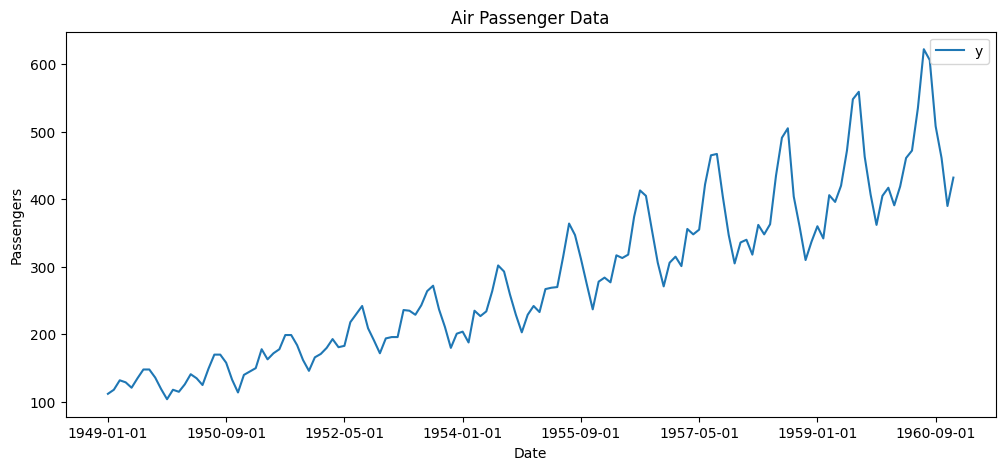

In [2]:
data = gmp.load_example_dataset("air_passenger", index_col=0)
data.plot(title="Air Passenger Data", figsize=(12, 5), xlabel="Date", ylabel="Passengers")
plt.show()

## Prepare data for training
Our goal is `forecasting`. To achieve this, we will prepare the data by:
1. Creating input sequences (features) from past observations and their corresponding target values (the future values to predict).
2. Normalizing these input sequences and target values.
3. Splitting the prepared data into training and testing sets.

In [3]:
# Prepare the data for training
N = len(data)
prev_vals = 10
prediction_horizon = 1
split_ratio = 0.8

# Initialize X and y
X = np.zeros((N - prev_vals - prediction_horizon + 1, prev_vals))
y = np.zeros((N - prev_vals - prediction_horizon + 1, 1))

# Create shifted values and targets
for i in range(prev_vals, N - prediction_horizon + 1):
    X[i - prev_vals] = data.iloc[i - prev_vals : i].to_numpy().flatten()
    y[i - prev_vals] = data.iloc[i + prediction_horizon - 1].to_numpy()

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split the data into training and test sets
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data shape: {data.shape}")
print(f"X_train shape: {X_train.shape},y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Print the first 3 train/test pairs
print("First 3 training pairs:")
for i in range(3):
    print(f"X_train[{i}]: {X_train[i]},\ny_train[{i}]: {y_train[i]}\n")

Data shape: (144, 1)
X_train shape: (107, 10),y_train shape: (107, 1)
X_test shape: (27, 10), y_test shape: (27, 1)
First 3 training pairs:
X_train[0]: [0.01758242 0.03076923 0.06153846 0.05494505 0.03736264 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753],
y_train[0]: [0.]

X_train[1]: [0.03076923 0.06153846 0.05494505 0.03736264 0.06813187 0.08494208
 0.08494208 0.06177606 0.02895753 0.        ],
y_train[1]: [0.02702703]

X_train[2]: [0.06153846 0.05494505 0.03736264 0.06813187 0.0967033  0.08494208
 0.06177606 0.02895753 0.         0.02702703],
y_train[2]: [0.02123552]



## Train model
With the data prepared, we can now define our model and proceed with training using a standard PyTorch approach. A key aspect of our setup involves configuring the optimizer with different initial learning rates for the predictor and gate components of the GHONN model.

In [ ]:
# Train the model
output_shape = 1
layer_size = 10
predictor_orders = [1, 2, 3]
gate_orders = [1, 2, 2, 1]
predictor_activations = "leaky_relu"
gate_activations = ["sigmoid"]
output_type = "linear"
bias = True

lr_predictor = 0.001
lr_gate = 0.01

batch_size = 8
epochs = 100

model = gmp.GHONN(
    X.shape[1],
    output_shape,
    layer_size,
    predictor_orders,
    gate_orders,
    predictor_activations=predictor_activations,
    gate_activations=gate_activations,
    output_type=output_type,
    bias=bias,
)

# Collect all predictor and gate parameters from each GHONU in the model
predictor_params = list(model.predictors.parameters())
gate_params = list(model.gates.parameters())

# Collect any other parameters not in predictors or gates (e.g., head)
all_params = set(model.parameters())
other_params = list(all_params - set(predictor_params) - set(gate_params))

optimizer = torch.optim.Adam(
    [
        {"params": predictor_params + other_params, "lr": lr_predictor},
        {"params": gate_params, "lr": lr_gate},
    ]
)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
loss_history_train = np.zeros(epochs)
loss_history_test = np.zeros(epochs)
model.train()
for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
    permutations = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        optimizer.zero_grad()
        indices = permutations[i : i + batch_size]
        X_batch = X_train_tensor[indices]
        y_batch = y_train_tensor[indices]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Store the loss for this epoch
    avg_loss = epoch_loss / (X_train_tensor.size(0) // batch_size)
    loss_history_train[epoch] = avg_loss

    # Evaluate on the test set
    epoch_loss_test = 0.0
    with torch.no_grad():
        for i in range(0, X_test_tensor.size(0), batch_size):
            X_batch = X_test_tensor[i : i + batch_size]
            y_batch = y_test_tensor[i : i + batch_size]

            # Forward pass
            y_pred = model(X_batch)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_test += loss.item()

    # Store the test loss for this epoch
    avg_loss_test = epoch_loss_test / (X_test_tensor.size(0) // batch_size)
    loss_history_test[epoch] = avg_loss_test

# Print the achieved training and test loss
print(f"Final training loss: {loss_history_train[-1]:.4f}")
print(f"Final test loss: {loss_history_test[-1]:.4f}")

Training: 100%|██████████| 100/100 [00:05<00:00, 19.35epoch/s]

Final training loss: 0.0020
Final test loss: 0.0059


## Visualize the model training results
After training the model, the next step is to visualize the training and testing loss. This helps in understanding how well the model learned from the training data and how it generalizes to unseen data. Since our model is in pytorch and we used common approach, no surprises linger around here

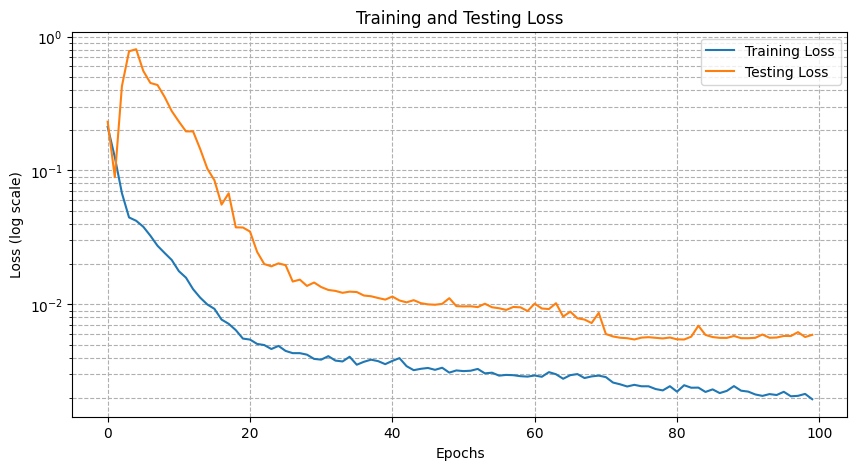

In [5]:
# Show training and testing loss on a log scale
plt.figure(figsize=(10, 5))
plt.plot(loss_history_train, label="Training Loss")
plt.plot(loss_history_test, label="Testing Loss")
plt.yscale("log")  # set y-axis to logarithmic scale
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()

## Visualize Model Predictions and Forecast
After training the model, we can visualize its performance by plotting its predictions against the original data. This includes:

* Predictions on the training dataset.
* Predictions on the test dataset.
* A multi-step forecast into the future, beyond the available data.

The following code cell generates these visualizations.

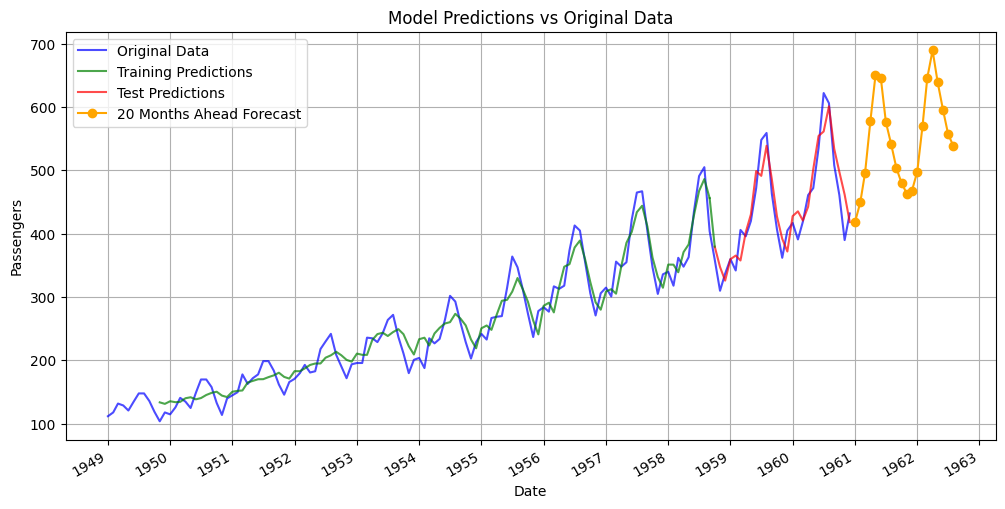

In [ ]:
# Visualize model predictions
plt.figure(figsize=(12, 6))

# Use the DataFrame's index as the time axis, converting to datetime objects
t = pd.to_datetime(data.index)

# Original data
plt.plot(t, data.values, label="Original Data", color="blue", alpha=0.7)

# Model predictions on training data
train_predictions = model(X_train_tensor).detach().numpy()
train_predictions = scaler_y.inverse_transform(train_predictions)
train_time = t[
    prev_vals + prediction_horizon - 1 : prev_vals + prediction_horizon - 1 + len(train_predictions)
]
plt.plot(train_time, train_predictions, label="Training Predictions", color="green", alpha=0.7)

# Model predictions on test data
test_predictions = model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
test_time = t[
    prev_vals + prediction_horizon - 1 + len(train_predictions) : prev_vals
    + prediction_horizon
    - 1
    + len(train_predictions)
    + len(test_predictions)
]
plt.plot(test_time, test_predictions, label="Test Predictions", color="red", alpha=0.7)

# Connect last train point to first test point
if len(train_predictions) and len(test_predictions):
    plt.plot(
        [train_time[-1], test_time[0]],
        [train_predictions[-1], test_predictions[0]],
        color="green",
        alpha=0.7,
    )

# --- Multi‐step forecast beyond end of data (e.g., 30 months ahead) ---
n_future = 20  # forecast 30 months ahead

# start from last test‐window (normalized)
window = X_test_tensor[-1].clone().squeeze()
future_norm = []

model.eval()
with torch.no_grad():
    for _ in range(n_future):
        pred = model(window.unsqueeze(0)).squeeze()
        future_norm.append(pred.item())
        window = torch.cat([pred.unsqueeze(0), window[:-1]])

# back to original scale
future_preds = scaler_y.inverse_transform(np.array(future_norm).reshape(-1, 1)).flatten()

# build future time axis using pandas date_range
last_time = test_time[-1]  # This will be a pandas Timestamp object
future_times = pd.date_range(start=last_time, periods=n_future + 1, freq="MS")[1:]

# Plot future predictions using datetime objects for the x-axis
plt.plot(
    future_times,
    future_preds,
    color="orange",
    marker="o",
    label=f"{n_future} Months Ahead Forecast",
)

# Plot settings
plt.title("Model Predictions vs Original Data")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()

# Format x-axis to show only years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels for better readability

plt.show()


## Model Description
The models in our library have a modified `__repr__` method, making them self-descriptive. Printing the model object, as demonstrated in the next cell, will display its structure and configuration.

In [ ]:
# Print top level architecture view
print(model)

GHONN(
  in_features=10,
  out_features=1,
  layer_size=10,
  output_type=linear,
  predictor_activation_functions=('leaky_relu',),
  gate_activation_functions=('sigmoid',),
  head=Linear(in_features=10, out_features=1, bias=True),
  ghonus=ModuleList(
  (0): GHONU(
    in_features=10, 
    predictor=HONU(in_features=10, polynomial_order=1, bias=True, activation=leaky_relu),
    gate=HONU(in_features=10, polynomial_order=1, bias=True, activation=sigmoid)
  )
  (1): GHONU(
    in_features=10, 
    predictor=HONU(in_features=10, polynomial_order=2, bias=True, activation=leaky_relu),
    gate=HONU(in_features=10, polynomial_order=2, bias=True, activation=sigmoid)
  )
  (2): GHONU(
    in_features=10, 
    predictor=HONU(in_features=10, polynomial_order=3, bias=True, activation=leaky_relu),
    gate=HONU(in_features=10, polynomial_order=2, bias=True, activation=sigmoid)
  )
  (3): GHONU(
    in_features=10, 
    predictor=HONU(in_features=10, polynomial_order=1, bias=True, activation=leaky

In [ ]:
# Print the named params with their sizes
for name, param in model.named_parameters():
    print(name, param.size())

ghonus.0.predictor.weight torch.Size([11])
ghonus.0.gate.weight torch.Size([11])
ghonus.1.predictor.weight torch.Size([66])
ghonus.1.gate.weight torch.Size([66])
ghonus.2.predictor.weight torch.Size([286])
ghonus.2.gate.weight torch.Size([66])
ghonus.3.predictor.weight torch.Size([11])
ghonus.3.gate.weight torch.Size([11])
ghonus.4.predictor.weight torch.Size([66])
ghonus.4.gate.weight torch.Size([11])
ghonus.5.predictor.weight torch.Size([286])
ghonus.5.gate.weight torch.Size([66])
ghonus.6.predictor.weight torch.Size([11])
ghonus.6.gate.weight torch.Size([66])
ghonus.7.predictor.weight torch.Size([66])
ghonus.7.gate.weight torch.Size([11])
ghonus.8.predictor.weight torch.Size([286])
ghonus.8.gate.weight torch.Size([11])
ghonus.9.predictor.weight torch.Size([11])
ghonus.9.gate.weight torch.Size([66])
head.weight torch.Size([1, 10])
head.bias torch.Size([1])


## Model Saving
Since all models in this library inherit from `torch.nn.Module`, they can be saved using standard PyTorch methods. The following cell demonstrates how to save the trained model's state dictionary.

In [9]:
save_path = "ghonn_air_passenger_model.pth"
# Save the model
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ghonn_air_passenger_model.pth
